In [10]:
import importlib
from SOAEpeaks import load_df
import phaseco as pc
from phaseco import *
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import scipy as sp
from scipy.signal.windows import gaussian
from scipy.optimize import curve_fit
import os
from collections import defaultdict

# FUNCTIONS

def get_is_signal(coherences, f, xis, f_target_idx, f_noise=12000, sample_hw=5, z_alpha=0.05, crop=False):
    f_noise_idx = (np.abs(f - f_noise)).argmin()  # find frequency bin index closest to our 12kHz cutoff
    # Get mean and std dev of coherence (over frequency axis, axis=0) for each xi value (using only "noise" frequencies above our cutoff)
    noise_means = np.mean(coherences[f_noise_idx:, :], axis=0) 
    noise_stds = np.std(coherences[f_noise_idx:, :], axis=0, ddof=1) # ddof=1 since we're using sample mean (not true mean) in sample std estimate
    # Now for each xi value, run a z-test to see if it's noise or not
    is_signal = np.full(len(xis), True, dtype=bool)
    for xi_idx in range(len(xis)):
        # Skip xi values that are too close to the edges to get a full sample
        if xi_idx < sample_hw:
            is_signal[xi_idx] = True
            continue
        elif xi_idx >= len(xis) - sample_hw:
            is_signal[xi_idx] = False
        coherence_sample = coherences[f_target_idx, xi_idx - sample_hw: xi_idx + sample_hw]
        # Calculate z test statistic
        sample_mean = np.mean(coherence_sample)
        z = (sample_mean - noise_means[xi_idx]) / (noise_stds[xi_idx]/np.sqrt(len(coherence_sample)))
        # Calculate p-value for a one-tailed test (sf = survival function = 1 - cdf)
        p = sp.stats.norm.sf(z)
        is_signal[xi_idx] = p < z_alpha
    target_coherences=coherences[f_target_idx, :]
    if crop:
        is_signal = is_signal[sample_hw:-sample_hw]
        xis = xis[sample_hw:-sample_hw]
        target_coherences = target_coherences[f_target_idx, sample_hw:-sample_hw]
    
    decayed_idx = -1
    # Find decayed point
    for i in range(len(is_signal)):
        if not crop and i < sample_hw: # These are automatically set to signal anyway but what the heck
            continue
        if not is_signal[i]:
            decayed_idx = i
            break
    if decayed_idx == -1:
        print(f"Signal at {f[f_target_idx]:.0f}Hz never decays!")
    xi_decayed = xis[decayed_idx]
    
    return is_signal, xis, target_coherences, xi_decayed, decayed_idx

def exp_decay(x, tc, amp):
    return amp * np.exp(-x/tc)

def gauss_decay(x, tc, amp):
    return amp * np.exp(-x**2/tc)

def sigmoid_amp(x, tc, amp):
    return amp / (1 + np.exp((x)/tc))

def sigmoid_loc(x, tc, loc):
    return 1 / (1 + np.exp((x-loc)/tc))

def sigmoid_amp_loc(x, tc, amp, loc):
    return amp / (1 + np.exp((x-loc)/tc))

# Get different species
df = load_df(laptop=True, dfs_to_load=["Curated Data"])
wf_list = []
for species in ['Anolis', 'Owl', 'Human']:
    df_species = df[df['species'] == species]
    for i in range (3):
        row = df_species.iloc[i]
        wf_fn = row['filepath'].split('\\')[-1]
        wf_list.append((row['wf'], row['sr'], wf_fn, species))
del df

Loading Curated Data
Combining into one Dataframe!


In [11]:

# Run various loops 
for rho in [0.7]:
    # Initialzie plot and storage dictionary
    N_xis = defaultdict(dict)
    for A_max in [1, np.inf]:
        for fit_func_type in ['exp', 'gauss', 'sigmoid_amp', 'sigmoid_loc', 'sigmoid_amp_loc']:
            # Skip some of the combos
            if (fit_func_type == 'sigmoid_amp') and (A_max == 1): # This kills all ability to fit
                continue
            if (fit_func_type == 'sigmoid_loc') and (A_max == 1): # A isn't even a parameter so just do one of these
                continue
            for plot_num, wf_idx in enumerate([0, 2, 4, 5, 6, 7]): # Started with 0, 2 (Lizard) - 4, 5 (Owl) - 6, 7 (Human)
                wf, fs, wf_fn, species = wf_list[wf_idx]

            
                # Set parameters (same for human and lizard)
                tau = 2**12 / 44100 # Everyone uses the same tau
                tauS = int(tau*fs)
                # Raise warning if tauS is not a power of two AND the samplerate is indeed 44100
                if np.log2(tauS) != int(np.log2(tauS)):
                    if fs == 44100:
                        raise ValueError("tauS is not a power of 2, but the samplerate is 44100!")
                    # else:
                    #     print(f"WARNING: tauS is not a power of 2, but the samplerate is {fs} (not 44100), so we'll assume you're just ensuring tau aligns with other waveforms!")
                

                if species == 'Human':
                    # Human parameters
                    min_xi = 0.001
                    max_xi = 1
                    delta_xi = 0.001
                    if wf_fn == 'human_TH14RearwaveformSOAE.mat':
                        max_xi = 2.5
                    max_khz = 6
                elif species in ['Lizard', 'Anolis']:
                    # Lizard parameters
                    min_xi = 0.001
                    max_xi = 0.1
                    delta_xi = 0.0005
                    max_khz = 6
                elif species == 'Owl':
                    # Owl parameters
                    min_xi = 0.001
                    max_xi = 0.1
                    delta_xi = 0.0005
                    max_khz = 12


                    
                    
                # Open coherences, or calculate if needed
                # suptitle=rf"[{wf_fn}]   [$\rho$={rho}]   [$\tau$={tau*1000:.2f}ms]"
                fn_id = rf"tau={tau*1000:.0f}, rho={rho}, {species}, {wf_fn.split('.')[0]}"
                pkl_fn = f'C_xi Decay Coherences - {fn_id}'
                pkl_folder = r'Pickles/'
                fig_folder = r'Colossogram Figures/C_xi Decay Figures/'
                
                
                if os.path.exists(pkl_folder + pkl_fn + '.pkl'):
                    with open(pkl_folder + pkl_fn + '.pkl', 'rb') as file:
                        coherences, f, xis, tau, rho, wf_fn, species = pickle.load(file)
                else:
                    print(f"Calculating coherences for {wf_fn} with rho={rho}")
                    num_xis = int((max_xi - min_xi) / delta_xi) + 1
                    xis = np.linspace(min_xi, max_xi, num_xis)

                    max_xiS = max(xis) * fs
                    f = rfftfreq(tauS, 1/fs)
                    # Make sure we have a consistent number of segments to take vector strength over since this will change with xi
                    N_segs = int((len(wf) - tauS) / max_xiS)    

                    coherences = np.zeros((len(f), len(xis)))
                    for i, xi in enumerate(xis):
                        coherences[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, rho=rho)[1]
                    
                    with open(pkl_folder + pkl_fn + '.pkl', 'wb') as file:
                        pickle.dump((coherences, f, xis, tau, rho, wf_fn, species), file)
                    
                
                # Peak pick the target bins
                if wf_fn == 'anole_AC6rearSOAEwfB1.mat': # 0
                    peak_freqs = [1225, 2150, 4300]
                    noise_freqs = [400, 12000]
                elif wf_fn == 'anole_ACsb18learSOAEwfG4.mat': # 2
                    peak_freqs = [990, 2000, 3670]
                    noise_freqs = [400, 12000]
                elif wf_fn == 'owl_Owl6L1.mat': # 4
                    peak_freqs = [4867, 6384, 7235]
                    noise_freqs = [400, 12000]
                elif wf_fn == 'owl_TAG4learSOAEwf1.mat': # 5
                    peak_freqs = [6280, 7820, 10487]
                    noise_freqs = [400, 12000]
                elif wf_fn == 'human_TH14RearwaveformSOAE.mat': # 6
                    peak_freqs = [603, 2250, 4370]
                    noise_freqs = [400, 12000]
                elif wf_fn == 'human_TH21RearwaveformSOAE.mat': # 7
                    peak_freqs = [2000, 2605, 4135]
                    noise_freqs = [400, 12000]
                else:
                    raise(Exception("Haven't peak picked this waveform yet!"))
                    

                bin_idxs = []
                bin_names = []

                for peak_freq in peak_freqs:
                    bin_idxs.append(np.argmin(np.abs(f - peak_freq)))
                    bin_names.append(f"{peak_freq:.0f}Hz Peak")

                # for noise_freq in noise_freqs:
                #     bin_idxs.append(np.argmin(np.abs(f - noise_freq)))
                #     bin_names.append(f"{noise_freq:.0f}Hz Noise")
                    
                # freq_list = peak_freqs + noise_freqs
                freq_list = peak_freqs
                
                
                "FIT and PLOT"

                # Z-Test Parameters
                sample_hw = 10
                z_alpha = 0.05 # Minimum p-value for z-test; we assume noise unless p < z_alpha (so higher z_alpha means more signal bins)

                # Fitting Parameters
                crop=False
                min_fit_xi_idx = 1
                trim_step = 10
                sigma_weighting_power = 1 # > 0 means less weight on lower coherence bins 
                # fit_func_type = 'sigmoid_amp'
                # A_max = np.inf # 1 or np.inf
                get_fit_sigma = lambda y, sigma_weighting_power: y/y # 1 / (y**sigma_weighting_power+ 1e-9)


                # Plotting parameters
                plot_noise = False
                # colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
                colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

                # Take care of effects of parameters

                # Take care of A restriction
                if fit_func_type!='sigmoid_loc':
                    if A_max == 1:
                        A_max_str = 'A in [0, 1]'
                    elif A_max == np.inf:
                        A_max_str = 'A in [0, infty]'
                    else:
                        raise(Exception("Invalid A_max"))
                else:
                    A_max_str = ''

                # Set default p0 / param3_label
                p0 = [1, 1]
                param3_label = None

                # Deal with different functions
                match fit_func_type:
                    case 'exp':
                        bounds = ([0, 0], [np.inf, A_max]) # [tc, amp]
                        fit_func = exp_decay
                        param2_label = 'A'
                    case 'gauss':
                        bounds = ([0, 0], [np.inf, A_max]) # [tc, amp]
                        fit_func = gauss_decay
                        param2 = 'A'
                    case 'sigmoid_amp':
                        bounds = ([0, 0], [np.inf, A_max]) # [tc, amp]
                        fit_func = sigmoid_amp
                        param2_label = 'A'
                    case 'sigmoid_loc':
                        bounds = ([0, -np.inf], [np.inf, np.inf]) # [tc, loc]
                        fit_func = sigmoid_loc
                        param2_label = 'loc'
                    case 'sigmoid_amp_loc': 
                        bounds = ([0, 0, -np.inf], [np.inf, A_max, np.inf]) # [tc, amp, loc]
                        fit_func = sigmoid_amp_loc
                        param2_label = 'A'
                        param3_label = 'loc'
                        p0 = [1, 1, 1]
                    

                # FIT AND STORE TCs
                
                
                
                N_xis_func_key = f"{fit_func_type}"
                if A_max_str != '':
                    N_xis_func_key = N_xis_func_key +f" - {A_max_str}"
                
                # Start the array where the TCs will be stored
                TCs = np.empty(3, dtype=tuple)
                for j, (f_target_idx, bin_name, color) in enumerate(zip(bin_idxs, bin_names, colors)):                    
                    # Calculate signal vs noise and point of decay
                    is_signal, xis_plot, target_coherences_plot, xi_decayed, decayed_idx = get_is_signal(coherences, f, xis, f_target_idx, f_noise=12000, sample_hw=sample_hw, z_alpha=z_alpha, crop=crop)
                    is_noise = ~is_signal

                    # Curve Fit
                    print(f"Fitting {fit_func_type} to {bin_name} with {A_max_str} on {wf_fn} with rho={rho}")
                    fit_start_idx = np.argmax(target_coherences_plot[min_fit_xi_idx:]) + min_fit_xi_idx
                    x_to_fit = xis_plot[fit_start_idx:decayed_idx]
                    y_to_fit = target_coherences_plot[fit_start_idx:decayed_idx]
                    sigma = get_fit_sigma(y_to_fit, sigma_weighting_power) 
                    attempts = 0
                    popt = None
                    while len(x_to_fit) > trim_step and popt is None:
                        try:
                            popt, pcov = curve_fit(fit_func, x_to_fit, y_to_fit, p0=p0, sigma=sigma, bounds=bounds)
                            break  # Fit succeeded!
                        except (RuntimeError, ValueError) as e:
                            attempts += 1
                            x_to_fit = x_to_fit[:-trim_step]
                            y_to_fit = y_to_fit[:-trim_step]
                            sigma = sigma[:-trim_step]
                            print(f"Fit failed (attempt {attempts}): — trimmed to {len(x_to_fit)} points")
                    if popt is None:
                        print(f"Curve fit failed after all attemps ({bin_name} from {wf_fn} with {fit_func_type} fit and {A_max_str})")
                        continue
                    else:
                        print("Fitting successful!")
                    y_fitted = fit_func(x_to_fit, *popt)
                    tc = popt[0]
                    # Get target frequency
                    f_target = f[f_target_idx]
                    # Get tc in number of cycles
                    tc_num_cycles = tc*f_target
                    TCs[j] = (f_target, tc_num_cycles)
                    
                # Add to dictionary
                N_xis[wf_fn][N_xis_func_key] = TCs

Fitting exp to 1225Hz Peak with A in [0, 1] on anole_AC6rearSOAEwfB1.mat with rho=0.7
Fitting successful!
Fitting exp to 2150Hz Peak with A in [0, 1] on anole_AC6rearSOAEwfB1.mat with rho=0.7
Fitting successful!
Fitting exp to 4300Hz Peak with A in [0, 1] on anole_AC6rearSOAEwfB1.mat with rho=0.7
Fitting successful!
Fitting exp to 990Hz Peak with A in [0, 1] on anole_ACsb18learSOAEwfG4.mat with rho=0.7
Fitting successful!
Fitting exp to 2000Hz Peak with A in [0, 1] on anole_ACsb18learSOAEwfG4.mat with rho=0.7
Fitting successful!
Signal at 3671Hz never decays!
Fitting exp to 3670Hz Peak with A in [0, 1] on anole_ACsb18learSOAEwfG4.mat with rho=0.7
Fitting successful!
Fitting exp to 4867Hz Peak with A in [0, 1] on owl_Owl6L1.mat with rho=0.7
Fitting successful!
Fitting exp to 6384Hz Peak with A in [0, 1] on owl_Owl6L1.mat with rho=0.7
Fitting successful!
Fitting exp to 7235Hz Peak with A in [0, 1] on owl_Owl6L1.mat with rho=0.7
Fitting successful!
Fitting exp to 6280Hz Peak with A in [0,

C:\Users\Owner\AppData\Local\Temp\ipykernel_28804\2215116319.py:66: RuntimeWarning: overflow encountered in exp
  return amp / (1 + np.exp((x)/tc))


Fitting sigmoid_amp to 603Hz Peak with A in [0, infty] on human_TH14RearwaveformSOAE.mat with rho=0.7
Fitting successful!
Fitting sigmoid_amp to 2250Hz Peak with A in [0, infty] on human_TH14RearwaveformSOAE.mat with rho=0.7
Fitting successful!
Fitting sigmoid_amp to 4370Hz Peak with A in [0, infty] on human_TH14RearwaveformSOAE.mat with rho=0.7
Fitting successful!
Fitting sigmoid_amp to 2000Hz Peak with A in [0, infty] on human_TH21RearwaveformSOAE.mat with rho=0.7
Fitting successful!
Fitting sigmoid_amp to 2605Hz Peak with A in [0, infty] on human_TH21RearwaveformSOAE.mat with rho=0.7
Fitting successful!
Fitting sigmoid_amp to 4135Hz Peak with A in [0, infty] on human_TH21RearwaveformSOAE.mat with rho=0.7
Fitting successful!
Fitting sigmoid_loc to 1225Hz Peak with  on anole_AC6rearSOAEwfB1.mat with rho=0.7
Fitting successful!
Fitting sigmoid_loc to 2150Hz Peak with  on anole_AC6rearSOAEwfB1.mat with rho=0.7
Fitting successful!
Fitting sigmoid_loc to 4300Hz Peak with  on anole_AC6rear

C:\Users\Owner\AppData\Local\Temp\ipykernel_28804\2215116319.py:69: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((x-loc)/tc))


Fitting successful!
Fitting sigmoid_loc to 7235Hz Peak with  on owl_Owl6L1.mat with rho=0.7
Fitting successful!
Fitting sigmoid_loc to 6280Hz Peak with  on owl_TAG4learSOAEwf1.mat with rho=0.7
Fitting successful!
Fitting sigmoid_loc to 7820Hz Peak with  on owl_TAG4learSOAEwf1.mat with rho=0.7
Fitting successful!
Fitting sigmoid_loc to 10487Hz Peak with  on owl_TAG4learSOAEwf1.mat with rho=0.7
Fitting successful!
Fitting sigmoid_loc to 603Hz Peak with  on human_TH14RearwaveformSOAE.mat with rho=0.7
Fitting successful!
Fitting sigmoid_loc to 2250Hz Peak with  on human_TH14RearwaveformSOAE.mat with rho=0.7
Fitting successful!
Fitting sigmoid_loc to 4370Hz Peak with  on human_TH14RearwaveformSOAE.mat with rho=0.7
Fitting successful!
Fitting sigmoid_loc to 2000Hz Peak with  on human_TH21RearwaveformSOAE.mat with rho=0.7
Fitting successful!
Fitting sigmoid_loc to 2605Hz Peak with  on human_TH21RearwaveformSOAE.mat with rho=0.7
Fitting successful!
Fitting sigmoid_loc to 4135Hz Peak with  on h

<Figure size 1200x1000 with 0 Axes>

['exp - A in [0, 1]', 'gauss - A in [0, 1]', 'sigmoid_amp_loc - A in [0, 1]', 'exp - A in [0, infty]', 'gauss - A in [0, infty]', 'sigmoid_amp - A in [0, infty]', 'sigmoid_loc', 'sigmoid_amp_loc - A in [0, infty]']
['exp - A in [0, 1]', 'gauss - A in [0, 1]', 'sigmoid_amp_loc - A in [0, 1]', 'exp - A in [0, infty]', 'gauss - A in [0, infty]', 'sigmoid_amp - A in [0, infty]', 'sigmoid_loc', 'sigmoid_amp_loc - A in [0, infty]']
['exp - A in [0, 1]', 'gauss - A in [0, 1]', 'sigmoid_amp_loc - A in [0, 1]', 'exp - A in [0, infty]', 'gauss - A in [0, infty]', 'sigmoid_amp - A in [0, infty]', 'sigmoid_loc', 'sigmoid_amp_loc - A in [0, infty]']
['exp - A in [0, 1]', 'gauss - A in [0, 1]', 'sigmoid_amp_loc - A in [0, 1]', 'exp - A in [0, infty]', 'gauss - A in [0, infty]', 'sigmoid_amp - A in [0, infty]', 'sigmoid_loc', 'sigmoid_amp_loc - A in [0, infty]']
['exp - A in [0, 1]', 'gauss - A in [0, 1]', 'sigmoid_amp_loc - A in [0, 1]', 'exp - A in [0, infty]', 'gauss - A in [0, infty]', 'sigmoid_a

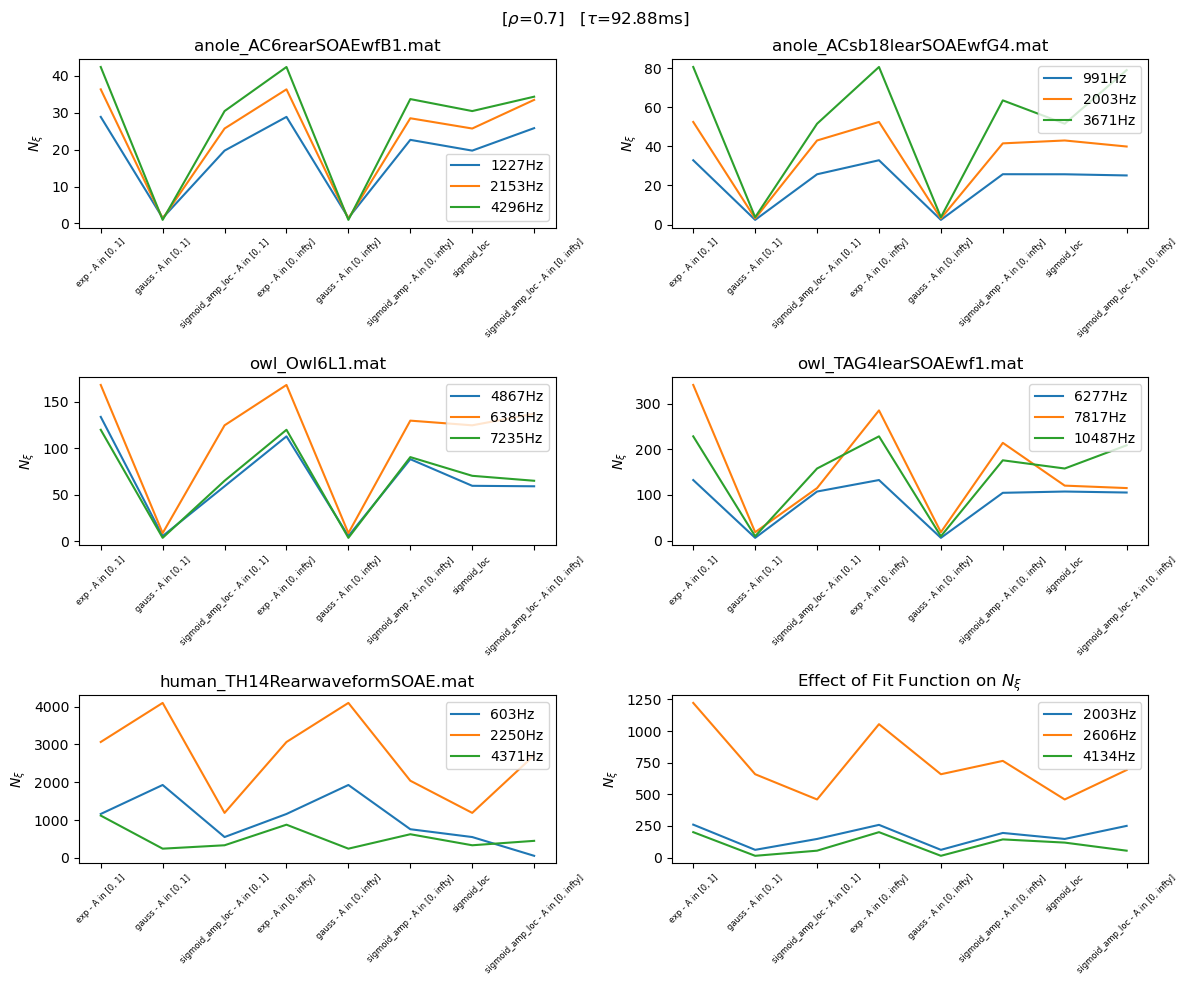

In [18]:
# PLOT
plt.close('all')
plt.figure(figsize=(12, 10))
for rho in [0.7]:
    for plot_num, wf_idx in enumerate([0, 2, 4, 5, 6, 7]): # Started with 0, 2 (Lizard) - 4, 5 (Owl) - 6, 7 (Human)
        plt.subplot(3, 2, plot_num + 1)
        wf, fs, wf_fn, species = wf_list[wf_idx]
        plt.title(wf_fn)
        N_xis_wf = N_xis[wf_fn]
        x_labels = list(N_xis_wf.keys())
        print(x_labels)
        x = np.arange(len(x_labels))
        for peak_idx in range(3): # for each peak we want to make a y array
            y = []
            label = N_xis_wf[x_labels[0]][peak_idx][0] # x_labels[0] because any xlabel will do 
            for l in range(len(x_labels)): # for each xlabel, append the corresponding y value
                y.append(N_xis_wf[x_labels[l]][peak_idx][1])
            y = np.array(y)
            plt.plot(x, y, label=f"{label:.0f}Hz")
        plt.legend()
        plt.xticks(x, x_labels, rotation=45, fontsize=6)
        plt.ylabel(r"$N_{\xi}$")
                        

    # Finish up plot
    plt.suptitle(rf"[$\rho$={rho}]   [$\tau$={tau*1000:.2f}ms]" )
    plt.title(rf"Effect of Fit Function on $N_{{\xi}}$")

    # Book it!
    plt.tight_layout()
    os.makedirs(fig_folder, exist_ok=True)    
    plt.savefig(f'{fig_folder}/Effect of Fit Function on N_xi (rho={rho}).png', dpi=300)
    # plt.show()
                    